## Test if zero wait times can be imputed using southbound data
1. From mungedata, set data to zero where waittime < 10 
2. Model with volume
3. Evaluate & remodel if necessary

In [1]:
from dbhelper import pd_query
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Start with analysis of wait time to volume at Peace Arch

In [2]:
query = '''
        select date, waittime, volume
        from crossingdata
        where crossing_id = 2
        '''

dfn = pd_query(query)

In [3]:
query = '''
        select date, waittime, volume
        from crossingdata
        where crossing_id = 1
        '''

dfs = pd_query(query)

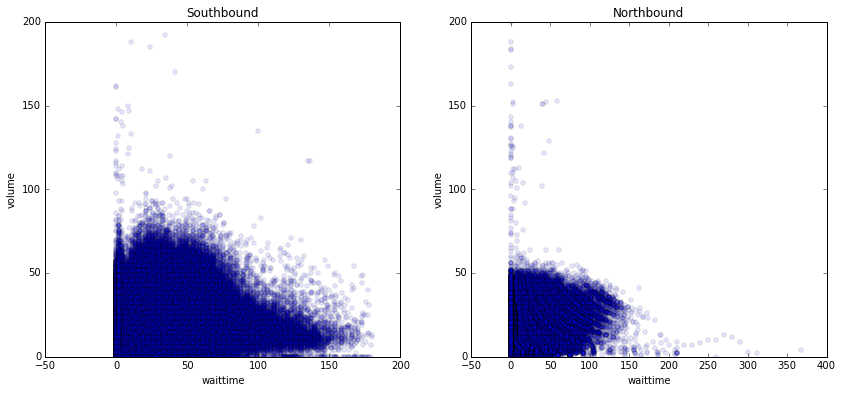

In [4]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.title('Southbound')
plt.xlabel('waittime')
plt.ylabel('volume')
plt.ylim([0,200])
plt.scatter(dfs.waittime, dfs.volume, alpha=.1)

plt.subplot(122)
plt.title('Northbound')
plt.xlabel('waittime')
plt.ylabel('volume')
plt.ylim([0,200])
plt.scatter(dfn.waittime, dfn.volume, alpha=.1);

In [5]:
print len(dfn[dfn.waittime != 0])
print len(dfn[dfn.waittime == 0])
print "Ratio"

396804
540924
Ratio


### Volume does not appear to be strongly correlated with wait time.  Model will need more features. 

Select from raw data since noise is more representative of northbound data.

In [6]:
query = '''
        select date, waittime, volume
        from crossingdata
        where crossing_id = 1
        and valid = 1
        and waittime is not null
        and volume is not null
        '''

df = pd_query(query)

In [7]:
df.head()

,date,waittime,volume
0,2007-01-01 00:00:00,0,3
1,2007-01-01 00:05:00,0,2
2,2007-01-01 00:10:00,0,2
3,2007-01-01 00:15:00,0,0
4,2007-01-01 00:20:00,0,0


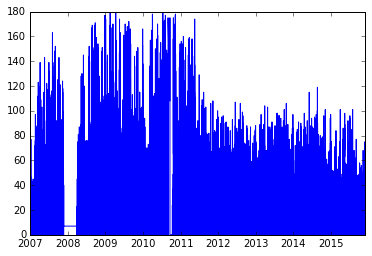

In [8]:
plt.plot(df.set_index('date').waittime);

## Create weighting for setting zeroes
For waittimes under 10, set a weight proportional to 10 - wait time

In [9]:
dfz = df.copy()

In [10]:
weight = 11 - dfz.waittime.clip(upper=11) 
weight = weight**2   # a little more weight near zero

In [11]:
sum(weight > 0)   # number of wait times under 11

540092

In [12]:
len(dfz)  # total number of points

813937

In [13]:
dfzero = dfz.sample(n=int(.85*sum(weight>0)), weights=weight)

In [14]:
dfzero.head()

,date,waittime,volume
294261,2010-05-28 22:50:00,1,6
341085,2011-03-15 05:10:00,0,1
533577,2013-02-24 21:25:00,0,10
788886,2015-09-03 04:15:00,0,0
520036,2013-01-08 08:15:00,0,17


In [15]:
dfz.isin(dfzero).date.values

array([ True,  True,  True, ...,  True, False, False], dtype=bool)

In [16]:
wt = dfz.copy().waittime.values

In [17]:
wt[dfz.isin(dfzero).date.values] = 0

In [18]:
dfz['wt'] = wt

In [19]:
dfz.head(10)

,date,waittime,volume,wt
0,2007-01-01 00:00:00,0,3,0
1,2007-01-01 00:05:00,0,2,0
2,2007-01-01 00:10:00,0,2,0
3,2007-01-01 00:15:00,0,0,0
4,2007-01-01 00:20:00,0,0,0
5,2007-01-01 00:25:00,2,1,0
6,2007-01-01 00:30:00,4,0,0
7,2007-01-01 00:35:00,3,0,0
8,2007-01-01 00:40:00,0,1,0
9,2007-01-01 00:45:00,0,1,0


In [20]:
dfz1 = dfz.set_index('date')

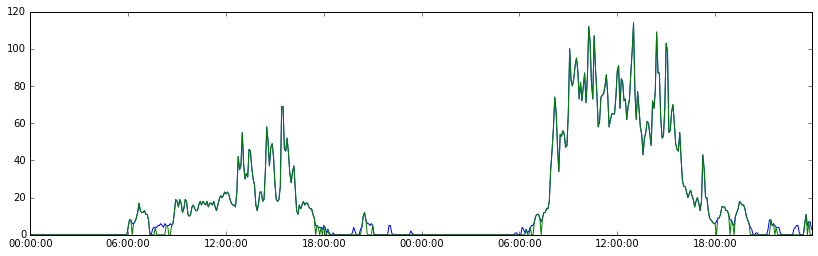

In [21]:
# dfztemp = dfz1[(dfz1.index >= '2015-03-02') & (dfz1.index < '2015-03-04')]
dfztemp = dfz1[(dfz1.index >= '2010-01-01') & (dfz1.index < '2010-01-03')]
plt.figure(figsize=(14,4))
plt.plot(dfztemp.waittime)
plt.plot(dfztemp.wt);

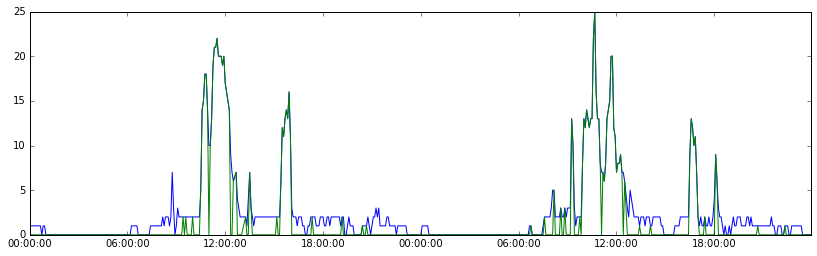

In [22]:
dfztemp = dfz1[(dfz1.index >= '2015-03-02') & (dfz1.index < '2015-03-04')]
# dfztemp = dfz1[(dfz1.index >= '2010-01-01') & (dfz1.index < '2010-01-02')]
plt.figure(figsize=(14,4))
plt.plot(dfztemp.waittime)
plt.plot(dfztemp.wt);

## 85% of wait times under 10 sec have been set to zero.  Now create a train and test set.
* Train is all non-zeros
* Test is all zeros

In [23]:
dfz1.head()

,waittime,volume,wt
date,,,
2007-01-01 00:00:00,0,3,0
2007-01-01 00:05:00,0,2,0
2007-01-01 00:10:00,0,2,0
2007-01-01 00:15:00,0,0,0
2007-01-01 00:20:00,0,0,0


In [24]:
X_train = dfz1[dfz1.wt != 0].volume.reshape(-1,1)
y_train = dfz1[dfz1.wt != 0].waittime
X_test = dfz1[dfz1.wt == 0].volume.reshape(-1,1)
y_test = dfz1[dfz1.wt == 0].waittime

In [25]:
from sklearn.ensemble import ExtraTreesRegressor

In [26]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(346629, 1)
(346629,)
(467308, 1)
(467308,)


In [27]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, oob_score=True, bootstrap=True)
model.fit(X_train, y_train)
yhat = model.predict(X_test)

In [28]:
model.oob_score_

0.018606762291781265

## Model is poor.  As expected, volume alone is a poor predictor

In [29]:
from sklearn.metrics import r2_score

In [30]:
r2_score(y_test, yhat)

-181.50101496268752

## Areas of improvement
1. Use smoothed volume data - volume is very noisy
2. Add date features - not convinced this helps when training data is missing
3. Model using adjacent data points
4. Span gaps with max value (with some noise)
5. Incorporate heuristics that combines multiple elements above

Suppose we define a probability distribution of wait times given volume and time of day.  Then for zero values, assign according to distribution.  Assume southbound distribution is representative.

### Analyze smoothed volume vs. waittime

In [205]:
query = '''
        select date, metric as volume
        from mungedata m
        where munger_id = 2
        and crossing_id = 1
        and is_waittime is false
        order by date
        '''

dfv = pd_query(query)

In [206]:
query = '''
        select date, waittime
        from crossingdata
        where crossing_id = 1
        and valid = 1
        and waittime is not null
        order by date
        '''

dfw = pd_query(query)

In [207]:
dfw.head()

,date,waittime
0,2007-01-01 00:00:00,0
1,2007-01-01 00:05:00,0
2,2007-01-01 00:10:00,0
3,2007-01-01 00:15:00,0
4,2007-01-01 00:20:00,0


In [208]:
dfv.describe().T

,count,mean,std,min,25%,50%,75%,max
volume,830594,13.645197,10.859282,0,4.509932,11.5537,20.2979,1118


In [209]:
dfv.head()

,date,volume
0,2007-01-01 00:05:00,1.920670
1,2007-01-01 00:10:00,1.571340
2,2007-01-01 00:15:00,1.244390
3,2007-01-01 00:20:00,0.929223
4,2007-01-01 00:25:00,0.619251


In [210]:
dfj = dfv.merge(dfw, on='date')

In [211]:
dfj.head()

,date,volume,waittime
0,2007-01-01 00:05:00,1.920670,0
1,2007-01-01 00:10:00,1.571340,0
2,2007-01-01 00:15:00,1.244390,0
3,2007-01-01 00:20:00,0.929223,0
4,2007-01-01 00:25:00,0.619251,2


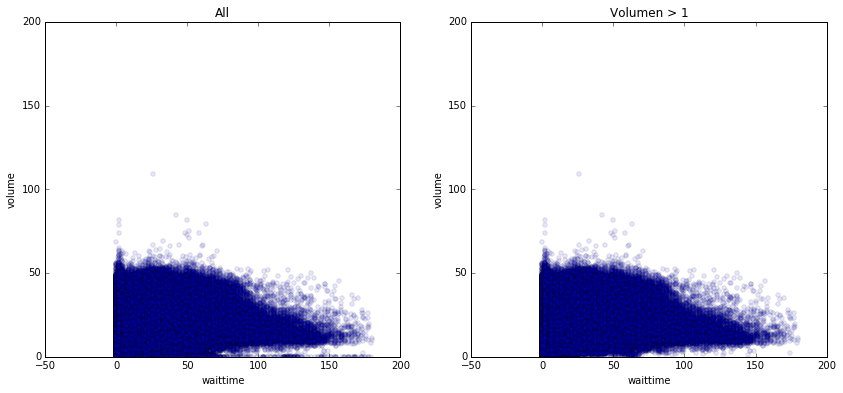

In [42]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.title('All')
plt.xlabel('waittime')
plt.ylabel('volume')
plt.ylim([0,200])
plt.scatter(dfj.waittime, dfj.volume, alpha=.1)

plt.subplot(122)
plt.title('Volume > 1')
plt.xlabel('waittime')
plt.ylabel('volume')
plt.ylim([0,200])
plt.scatter(dfj[dfj.volume > 1].waittime, dfj[dfj.volume > 1].volume, alpha=.1);

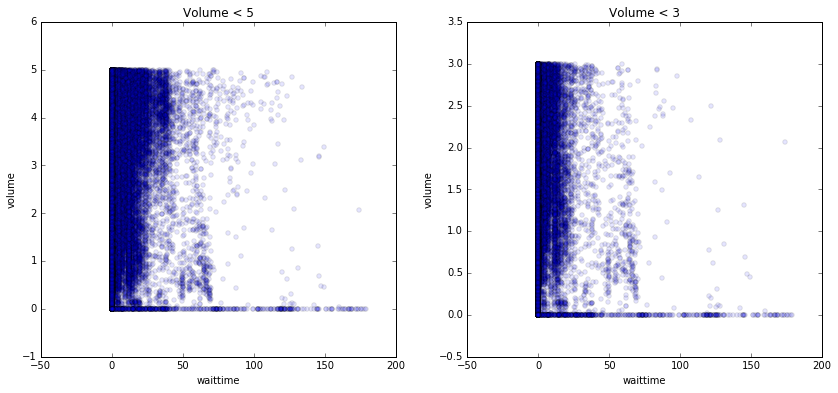

In [44]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.title('Volume < 5')
plt.xlabel('waittime')
plt.ylabel('volume')
plt.scatter(dfj[dfj.volume < 5].waittime, dfj[dfj.volume < 5 ].volume, alpha=.1);

plt.subplot(122)
plt.title('Volume < 3')
plt.xlabel('waittime')
plt.ylabel('volume')
plt.scatter(dfj[dfj.volume < 3].waittime, dfj[dfj.volume < 3 ].volume, alpha=.1);

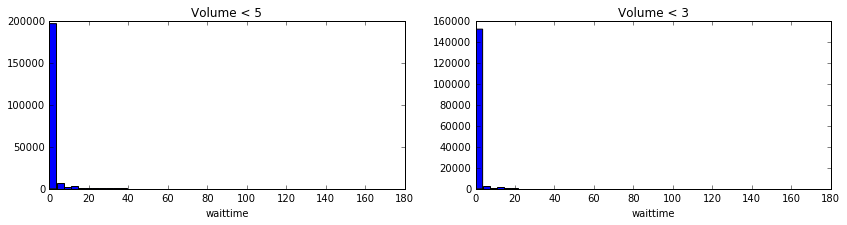

In [48]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plt.title('Volume < 5')
plt.xlabel('waittime')
plt.hist(dfj[dfj.volume < 5].waittime, bins=50)

plt.subplot(122)
plt.title('Volume < 3')
plt.xlabel('waittime')
plt.hist(dfj[dfj.volume < 3].waittime, bins=50);

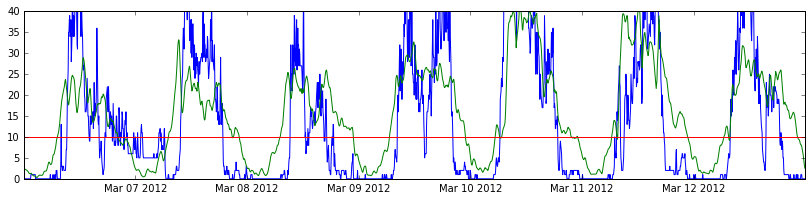

In [102]:
plt.figure(figsize=(14,3))
plt.ylim([0,40])
plt.plot(dfj[(dfj.date>'2012-3-6') & (dfj.date<'2012-3-13')].set_index('date'))
plt.axhline(10, color='r');

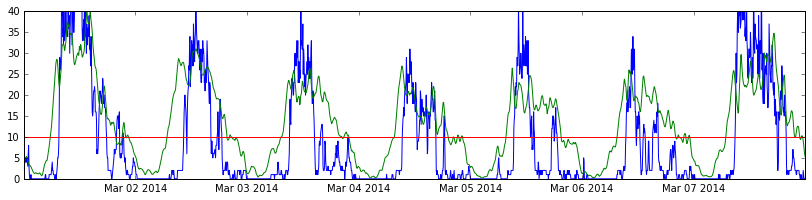

In [101]:
plt.figure(figsize=(14,3))
plt.ylim([0,40])
plt.plot(dfj[(dfj.date>'2014-3-1') & (dfj.date<'2014-3-8')].set_index('date'))
plt.axhline(10, color='r');

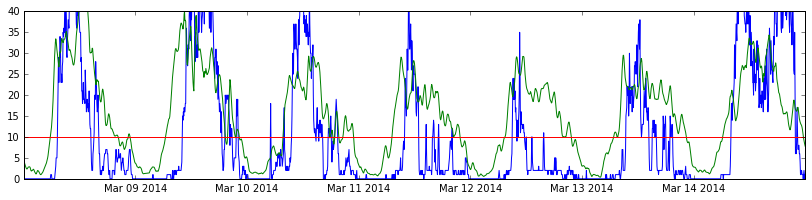

In [104]:
plt.figure(figsize=(14,3))
plt.ylim([0,40])
plt.plot(dfj[(dfj.date>'2014-3-8') & (dfj.date<'2014-3-15')].set_index('date'))
plt.axhline(10, color='r');

### Findings
1. Below ~10 volume, waittime = 0
    * except on sunday evenings


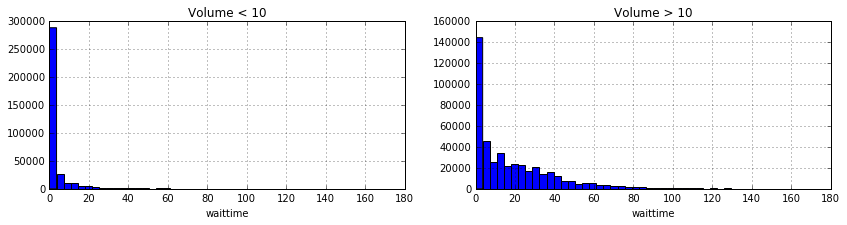

In [118]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plt.title('Volume < 10')
plt.xlabel('waittime')
dfj[dfj.volume < 10].waittime.hist(bins=50)

plt.subplot(122)
plt.title('Volume > 10')
plt.xlabel('waittime')
dfj[dfj.volume > 10].waittime.hist(bins=50);

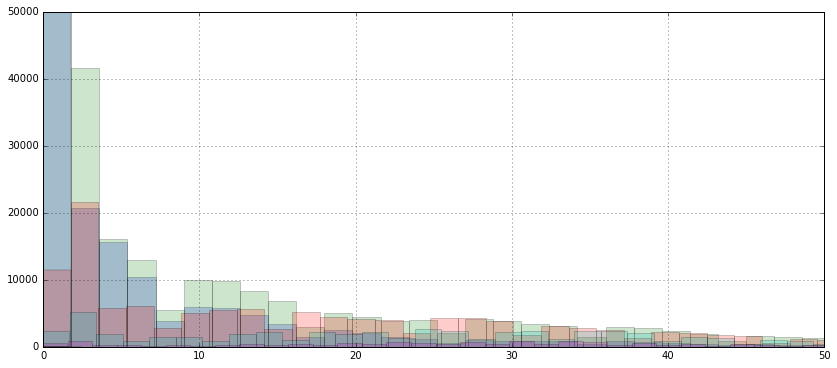

In [134]:
plt.figure(figsize=(14,6))
step = 10

for i in range(0, 60, step):
    dfj[(dfj.volume >= i) & (dfj.volume < i + step)].waittime.hist(bins=100, alpha=.2)

plt.xlim([0,50])
plt.ylim([0,50000])
plt.show();

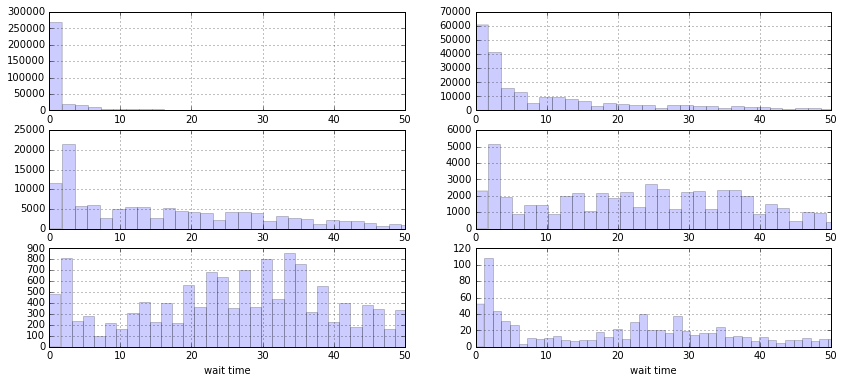

In [144]:
plt.figure(figsize=(14,6))
step = 10

for i in range(0, 60, step):
    plt.subplot(3, 2, i / step + 1)
    dfj[(dfj.volume >= i) & (dfj.volume < i + step)].waittime.hist(bins=100, alpha=.2)
    plt.xlim([0,50])
    plt.xlabel('wait time')
plt.show();


## Model Peace Arch southbound data with volume and date features

In [212]:
query = '''
        select date, year, month, dayofweek, hour
        from datefeatures
        '''

dft = pd_query(query)

dfj = dfj.merge(dft, on='date')

y = dfj.waittime
X = dfj.drop(['date','waittime'], 1)

In [214]:
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, oob_score=True, bootstrap=True)
model.fit(X, y)
print model.oob_score_

0.747823408185


## Validate against Pacific Highway south data with zeros removed

In [158]:
query = '''
        select date, metric as volume
        from mungedata m
        where munger_id = 2
        and crossing_id = 5
        and is_waittime is false
        order by date
        '''

dfphv = pd_query(query)

query = '''
        select date, waittime
        from crossingdata
        where crossing_id = 5
        and valid = 1
        and waittime is not null
        order by date
        '''

dfphw = pd_query(query)

### prepare dataset with wait time < 10 set to zero sporadically

In [159]:
dfph = dfphv.merge(dfphw, on='date')

In [160]:
len(dfph)

842630

In [175]:
weight = 10 - dfph.waittime.clip(upper=10) 
weight = weight**2   # a little more weight near zero

In [176]:
sum(weight > 0)   # number of wait times under 11

552702

In [177]:
dfphz = dfph.sample(n=int(.85*sum(weight>0)), weights=weight)  # select rows to set to zero

In [178]:
wt_new = dfph.copy().waittime.values     # create a new waittime value which matches sample
wt_new[dfph.isin(dfphz).date.values] = 0

In [179]:
dfph['wt_new'] = wt_new

In [180]:
dfph.head(20)

,date,volume,waittime,wt_new
0,2007-01-01 00:05:00,2.02127,1,1
1,2007-01-01 00:10:00,1.83179,0,0
2,2007-01-01 00:15:00,1.68238,0,0
3,2007-01-01 00:20:00,1.57438,0,0
4,2007-01-01 00:25:00,1.52900,0,0
5,2007-01-01 00:30:00,1.92317,0,0
6,2007-01-01 00:35:00,2.37534,0,0
7,2007-01-01 00:40:00,2.79511,0,0
8,2007-01-01 00:45:00,3.19051,1,0
9,2007-01-01 00:50:00,3.48583,1,0


In [ ]:
dfph = dfph.set_index('date')

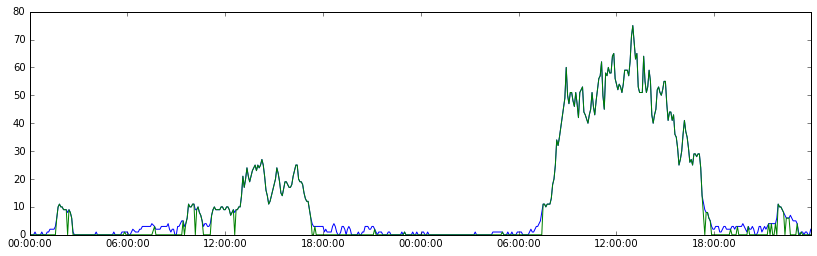

In [184]:
dfphtemp = dfph[(dfph.index >= '2010-01-01') & (dfph.index < '2010-01-03')]
plt.figure(figsize=(14,4))
plt.plot(dfphtemp.waittime)
plt.plot(dfphtemp.wt_new);

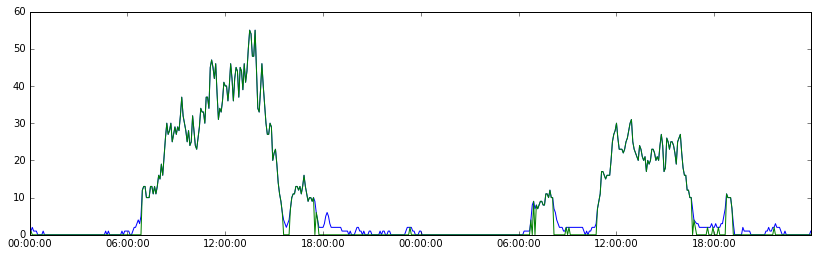

In [185]:
dfphtemp = dfph[(dfph.index >= '2014-03-01') & (dfph.index < '2014-03-03')]
plt.figure(figsize=(14,4))
plt.plot(dfphtemp.waittime)
plt.plot(dfphtemp.wt_new);

In [191]:
dfph = dfph.join(dft.set_index('date'))

In [194]:
dfph.head()

,volume,waittime,wt_new,year,month,dayofweek,hour
date,,,,,,,
2007-01-01 00:05:00,2.02127,1,1,2007,1,0,0
2007-01-01 00:10:00,1.83179,0,0,2007,1,0,0
2007-01-01 00:15:00,1.68238,0,0,2007,1,0,0
2007-01-01 00:20:00,1.57438,0,0,2007,1,0,0
2007-01-01 00:25:00,1.52900,0,0,2007,1,0,0


In [217]:
# y_train = dfph[dfph.wt_new != 0].waittime
# X_train = dfph[dfph.wt_new != 0].drop('waittime', 1)
y_test = dfph[dfph.wt_new == 0].waittime
X_test = dfph[dfph.wt_new == 0].drop(['wt_new', 'waittime'], 1)

In [218]:
X.head()

,volume,year,month,dayofweek,hour
0,1.920670,2007,1,0,0
1,1.571340,2007,1,0,0
2,1.244390,2007,1,0,0
3,0.929223,2007,1,0,0
4,0.619251,2007,1,0,0


In [219]:
X_test.head()

,volume,year,month,dayofweek,hour
date,,,,,
2007-01-01 00:10:00,1.83179,2007,1,0,0
2007-01-01 00:15:00,1.68238,2007,1,0,0
2007-01-01 00:20:00,1.57438,2007,1,0,0
2007-01-01 00:25:00,1.52900,2007,1,0,0
2007-01-01 00:30:00,1.92317,2007,1,0,0


In [220]:
# model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, oob_score=True, bootstrap=True)
# model.fit(X_train, y_train)
yhat = model.predict(X_test)

In [221]:
r2_score(y_test, yhat)

-24.792626159604048

In [223]:
dftemp = dfph.copy()[dfph.wt_new == 0]
dftemp['yhat'] = yhat

In [224]:
dftemp.head()

,volume,waittime,wt_new,year,month,dayofweek,hour,yhat
date,,,,,,,,
2007-01-01 00:10:00,1.83179,0,0,2007,1,0,0,1.89
2007-01-01 00:15:00,1.68238,0,0,2007,1,0,0,1.09
2007-01-01 00:20:00,1.57438,0,0,2007,1,0,0,0.25
2007-01-01 00:25:00,1.52900,0,0,2007,1,0,0,0.23
2007-01-01 00:30:00,1.92317,0,0,2007,1,0,0,3.63


### Predictions are consistently overestimated
Possibly a scaling issue between crossings

More importantly, the model is making a prediction without any information about nearby data

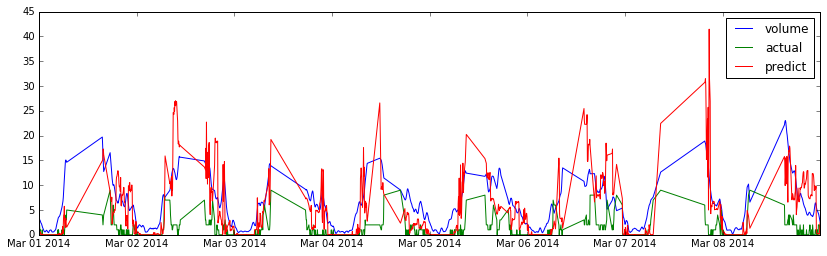

In [239]:
dfphtemp = dftemp[(dftemp.index >= '2014-03-01') & (dftemp.index < '2014-03-09')]
plt.figure(figsize=(14,4))
plt.plot(dfphtemp.volume, label='volume')
plt.plot(dfphtemp.waittime, label='actual')
plt.plot(dfphtemp.yhat, label='predict')
plt.legend();